# Klasyfikator spamu

Celem niniejszego projektu jest stworzenie klasyfikatora, będączego w stanie rozróżniać porządane maile od spamu, na podstawie ich zawartości. Do uczenia modeli wykorzystam następujący zbiór danych: [https://www.kaggle.com/datasets/chandramoulinaidu/spam-classification-for-basic-nlp?resource=download]

In [2]:
import pandas as pd

df = pd.read_csv('./data.csv')

df.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [3]:
df['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

Wiadomości o kategorii 1 to spam, z 0 to normalne maile. Widać pewną dysproporcję pomiędzy liczebnościami obydwu kategorii.

## Przygotowanie danych

In [4]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krzys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krzys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\krzys\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()



Poniższa funkcja tokenizuje i lematyzuje teksty.

In [6]:
def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t not in stopwords]

  return useful_tokens

Podzial zbioru danych na uczący i testowy

In [7]:
df = df.sample(frac=1, random_state=1)
df = df.reset_index(drop=True)

split_index = int(len(df) * 0.8)
train_df, test_df = df[:split_index], df[split_index:]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
token_counter = {}

for msg in train_df['MESSAGE']:
    tokens = message_to_token_list(msg)

    for t in tokens:
        if t in token_counter:
            token_counter[t] += 1
        else:
            token_counter[t] = 1

ekstrakcja featurów

In [9]:
def keep_token(processed_token, trashold):
    if processed_token not in token_counter:
        return False
    else:
        return token_counter[processed_token] > trashold

In [10]:
features = set()

for token in token_counter:
    if keep_token(token, 10000):
        features.add(token)

In [11]:
token_to_index_mapping = {t:i for t, i in zip(features, range(len(features)))}
token_to_index_mapping 

{'font': 0,
 'com': 1,
 'td': 2,
 'p': 3,
 'tr': 4,
 '3d': 5,
 'b': 6,
 'size': 7,
 'http': 8,
 'br': 9}

konwersja do bag of words

In [12]:
import numpy as np

def message_to_count_vector(message):
  count_vector = np.zeros(len(features))

  processed_list_of_tokens = message_to_token_list(message)

  for token in processed_list_of_tokens:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1
  
  return count_vector

In [13]:
def df_to_X_y(dff):
  y = dff['CATEGORY'].to_numpy().astype(int)

  message_col = dff['MESSAGE']
  count_vectors = []

  for message in message_col:
    count_vector = message_to_count_vector(message)
    count_vectors.append(count_vector)

  X = np.array(count_vectors).astype(int)

  return X, y

In [14]:
X_train, y_train = df_to_X_y(train_df)

X_test, y_test = df_to_X_y(test_df)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4636, 10), (4636,), (1160, 10), (1160,))

## trenowanie modeli

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       788
           1       0.99      0.32      0.48       372

    accuracy                           0.78      1160
   macro avg       0.87      0.66      0.67      1160
weighted avg       0.83      0.78      0.74      1160

Precyzja modelu regresji logistycznej wynosi 78.10344827586206%


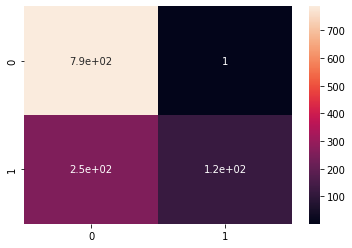

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

lr = LogisticRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print("Precyzja modelu regresji logistycznej wynosi {}%".format(acc*100))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       788
           1       0.92      0.58      0.71       372

    accuracy                           0.85      1160
   macro avg       0.87      0.78      0.80      1160
weighted avg       0.86      0.85      0.84      1160

Precyzja modelu lasu losowego wynosi 84.74137931034483%


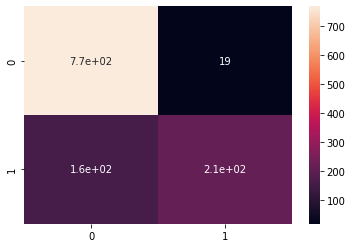

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_pred, y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print("Precyzja modelu lasu losowego wynosi {}%".format(acc*100))